In [11]:
import importlib  
import pandas as pd
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,mean_absolute_error,classification_report
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
import gc
from ipynb.fs.full.SIFT_to_Features import get_descriptors,get_vocab,descriptor_to_vocab,normalize_histograms
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#Simplifies adding a layer
def Convolution(input_tensor,filters):

    x = layers.Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same', activation = 'relu')(input_tensor)

    return x

def Convolution1D(input_tensor,filters):

    x = layers.Conv1D(filters=filters,kernel_size=(3),padding = 'same', activation = 'relu')(input_tensor)

    return x

#Simple CNN model
#Conv stands for neural network layers of (x,y). x standing for the input layers and y standing for how many filter layers there are
#maxp is a pooling layer that reduces the number of nodes of the next layer
#flatten changes the previous layer to a 1 dimensional layer
#dense layers have each node connected to every node in the previous layer. In this case, we have 3 dense layers of differing weights representing
#age, gender, and race. While all previous layers have collected features, dense layers calculate based on these collected features.
#They then send their calculations to the final dense layer to determine classification
#Binary Crossentropy = Classifies based on a binary value
#Sparse Categorical Crossentropy = Classifies based on an integer value with more than 2 possible values
def Simplemodel(input_shape,column):
  losstype = ""
  outputn = 0
  if(column == 'age'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 9
  if(column == 'gender'):
    losstype = "binary_crossentropy"
    outputn = 1
  if(column == 'race'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 5
    


  inputs = Input((input_shape))
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,64)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,64)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  conv_5 = Convolution(maxp_4,64)
  flatten= Flatten() (conv_5)
  dense_1= Dense(64,activation='relu')(flatten)
  output_1= Dense(outputn,activation="sigmoid",name='out')(dense_1)
  model = Model(inputs=[inputs], outputs=[output_1])
  model.compile(loss=[losstype], optimizer="Adam",
  metrics=["accuracy"])

  return model

def Simplemodel1D(input_shape,column):
  losstype = ""
  outputn = 0
  if(column == 'age'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 9
  if(column == 'gender'):
    losstype = "binary_crossentropy"
    outputn = 1
  if(column == 'race'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 5

  inputs = Input((input_shape))
  conv_1= Convolution1D(inputs,32)
  maxp_1 = MaxPooling1D(pool_size = 2) (conv_1)
  conv_2 = Convolution1D(maxp_1,64)
  maxp_2 = MaxPooling1D(pool_size = 2) (conv_2)
  conv_3 = Convolution1D(maxp_2,64)
  maxp_3 = MaxPooling1D(pool_size = 2) (conv_3)
  conv_4 = Convolution1D(maxp_3,64)
  maxp_4 = MaxPooling1D(pool_size = 2) (conv_4)
  conv_5 = Convolution1D(maxp_4,64)
  flatten= Flatten() (conv_5)
  dense_1= Dense(64,activation='relu')(flatten)
  output_1= Dense(outputn,activation="sigmoid",name='out')(dense_1)
  model = Model(inputs=[inputs], outputs=[output_1])
  model.compile(loss=[losstype], optimizer="Adam",
  metrics=["accuracy"])

  return model

### Set Labels and sample size

In [3]:
Labeltype = 'age'
samplesize = 5000

### Train test split imported data and balance train

In [4]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(samplesize/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples)).sample(frac=1)

### Count unbalanced, balanced, & balanced + sampled classes

In [5]:
# Count and print unbalanced classes
counter = Counter(y_train_2)
for k,v in counter.items():
    per = v / len(y_train_2) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=6093 (42.839%)
Class=2, n=331 (2.327%)
Class=6, n=2393 (16.825%)
Class=0, n=969 (6.813%)
Class=8, n=396 (2.784%)
Class=7, n=2405 (16.909%)
Class=3, n=231 (1.624%)
Class=4, n=954 (6.707%)
Class=1, n=451 (3.171%)
Class=5, n=6093 (11.111%)
Class=2, n=6093 (11.111%)
Class=6, n=6093 (11.111%)
Class=0, n=6093 (11.111%)
Class=8, n=6093 (11.111%)
Class=7, n=6093 (11.111%)
Class=3, n=6093 (11.111%)
Class=4, n=6093 (11.111%)
Class=1, n=6093 (11.111%)
Class=2, n=555 (11.111%)
Class=4, n=555 (11.111%)
Class=5, n=555 (11.111%)
Class=7, n=555 (11.111%)
Class=0, n=555 (11.111%)
Class=8, n=555 (11.111%)
Class=1, n=555 (11.111%)
Class=6, n=555 (11.111%)
Class=3, n=555 (11.111%)


### Function to get image data from urls

In [6]:
def get_images(filelist,rgb = True):
    dims = 0
    if(rgb):
        dims=3
    else:
        dims=1
    container = np.zeros((len(filelist),200,200,dims))
    for index,i in enumerate(filelist):
        img = cv2.imread(i)
        if(not rgb):
            img = color.rgb2gray(img)
        container[index,:,:,:dims]=img
    return container

### Image data of unbalanced train,test, and validation

In [8]:
train_img_container = get_images(X_train_2,rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)

### Clear data if necessary

In [79]:
del train_img_container
del validation_img_container
del test_img_container
del Modelsimple

NameError: name 'train_img_container' is not defined

### Flatten Images

In [8]:
flattenshape = (200*200*len(train_img_container[0,0,0,:]))
train_img_container = train_img_container.reshape(len(train_img_container),200*200*3)
validation_img_container = validation_img_container.reshape(len(validation_img_container),200*200*3)
test_img_container = test_img_container.reshape(len(test_img_container),200*200*3)

### Get y values

In [42]:
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

### Initialize callback

In [43]:
callback = tf.keras.callbacks.EarlyStopping(
monitor="val_accuracy",
verbose=1,
patience = 10,
mode="auto",
restore_best_weights=True,
)

### Create and run unbalanced model

In [11]:
Modelsimple=Simplemodel(train_img_container[0].shape,'age')

In [12]:
History = Modelsimple.fit(train_img_container[:5000]
                          ,y_train_2[:5000]
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 158s 998ms/step - loss: 2.4287 - accuracy: 0.4292 - val_loss: 1.5806 - val_accuracy: 0.4670
Epoch 2/10
157/157 [==============================] - 129s 824ms/step - loss: 1.4140 - accuracy: 0.5086 - val_loss: 1.3699 - val_accuracy: 0.5279
Epoch 3/10
157/157 [==============================] - 130s 828ms/step - loss: 1.3292 - accuracy: 0.5406 - val_loss: 1.3453 - val_accuracy: 0.5343
Epoch 4/10
157/157 [==============================] - 126s 802ms/step - loss: 1.2557 - accuracy: 0.5676 - val_loss: 1.2874 - val_accuracy: 0.5497
Epoch 5/10
157/157 [==============================] - 126s 803ms/step - loss: 1.1955 - accuracy: 0.5816 - val_loss: 1.2323 - val_accuracy: 0.5642
Epoch 6/10
157/157 [==============================] - 126s 806ms/step - loss: 1.1403 - accuracy: 0.6014 - val_loss: 1.2227 - val_accuracy: 0.5697
Epoch 7/10
157/157 [==============================] - 126s 803ms/step - loss: 1.0990 - accuracy: 0.6106 - val_loss: 1.2408 -

### Get predictions

In [13]:
ypredtrain = Modelsimple.predict(train_img_container[:5000])
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 26s 169ms/step


### Train classification report

In [14]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_2[:5000]))

              precision    recall  f1-score   support

           0       0.97      0.47      0.64       660
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.05      0.47      0.08        32
           5       0.88      0.76      0.82      2525
           6       0.47      0.56      0.51       692
           7       0.76      0.65      0.70       990
           8       0.45      0.62      0.52       101

    accuracy                           0.67      5000
   macro avg       0.40      0.39      0.36      5000
weighted avg       0.80      0.67      0.72      5000



C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### Validation classification report

In [15]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.48      0.91      0.63       308
           1       0.00      0.00      0.00       157
           2       0.00      0.00      0.00        95
           3       0.00      0.00      0.00        92
           4       0.22      0.01      0.03       336
           5       0.67      0.80      0.73      2073
           6       0.34      0.28      0.31       806
           7       0.49      0.62      0.54       729
           8       0.49      0.30      0.38       145

    accuracy                           0.56      4741
   macro avg       0.30      0.32      0.29      4741
weighted avg       0.49      0.56      0.51      4741



C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Test classification report

In [16]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.52      0.92      0.66       328
           1       0.00      0.00      0.00       150
           2       0.00      0.00      0.00       107
           3       0.00      0.00      0.00        64
           4       0.15      0.01      0.02       304
           5       0.68      0.81      0.74      2064
           6       0.39      0.31      0.34       793
           7       0.52      0.64      0.58       799
           8       0.49      0.34      0.40       132

    accuracy                           0.59      4741
   macro avg       0.31      0.34      0.31      4741
weighted avg       0.51      0.59      0.54      4741



C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Change label and title based on label type chosen

In [17]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Confusion matrix for validation

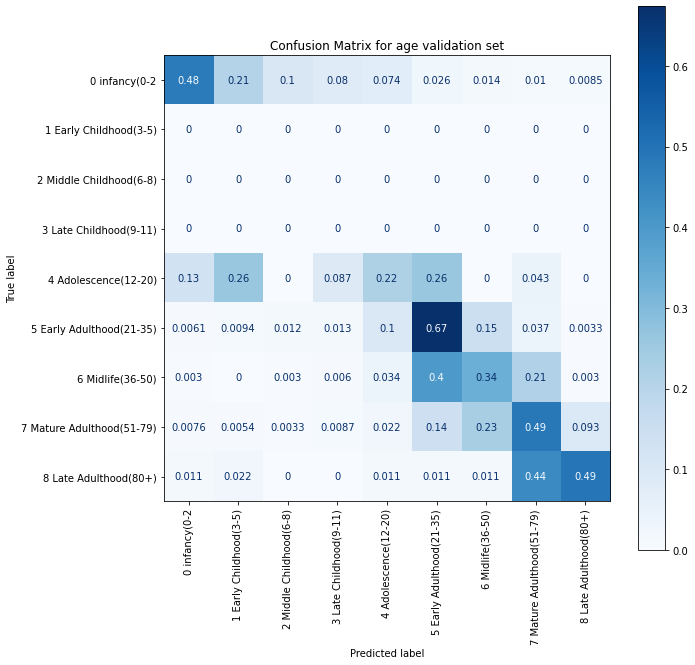

In [18]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Confusion matrix for test

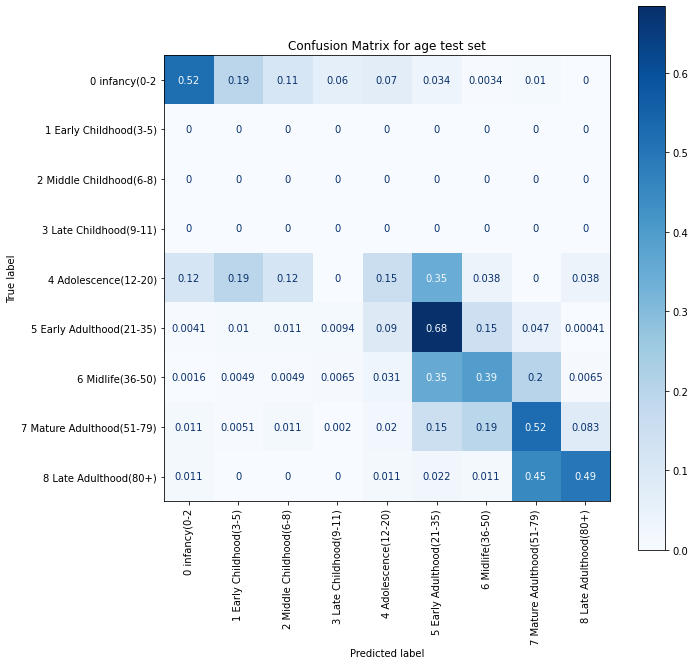

In [19]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Model accuracy

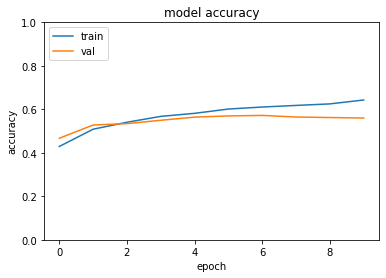

In [20]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model loss

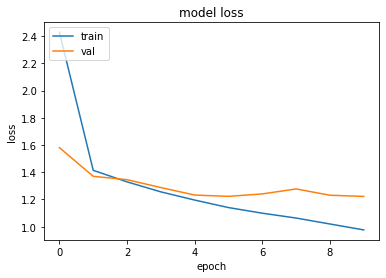

In [21]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Create and run balanced dataset

In [48]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)

### Create balanced model

In [65]:
Modelsimple=Simplemodel(train_img_container[0].shape,'age')

In [66]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 142s 900ms/step - loss: 2.6106 - accuracy: 0.1734 - val_loss: 2.0185 - val_accuracy: 0.2877
Epoch 2/10
157/157 [==============================] - 131s 835ms/step - loss: 1.9443 - accuracy: 0.2565 - val_loss: 2.0194 - val_accuracy: 0.2464
Epoch 3/10
157/157 [==============================] - 131s 837ms/step - loss: 1.6704 - accuracy: 0.3528 - val_loss: 1.4521 - val_accuracy: 0.4758
Epoch 4/10
157/157 [==============================] - 131s 837ms/step - loss: 1.4283 - accuracy: 0.4533 - val_loss: 1.4982 - val_accuracy: 0.4377
Epoch 5/10
157/157 [==============================] - 134s 852ms/step - loss: 1.2526 - accuracy: 0.5283 - val_loss: 1.4618 - val_accuracy: 0.4347
Epoch 6/10
157/157 [==============================] - 129s 825ms/step - loss: 1.0999 - accuracy: 0.5782 - val_loss: 1.4366 - val_accuracy: 0.4210
Epoch 7/10
157/157 [==============================] - 130s 831ms/step - loss: 0.9510 - accuracy: 0.6422 - val_loss: 1.5277 -

### Get predictions

In [67]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 20s 135ms/step


### Train classification report

In [68]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       657
           1       0.83      0.86      0.85       540
           2       0.69      0.97      0.80       392
           3       0.87      0.97      0.92       495
           4       0.93      0.68      0.78       763
           5       0.65      0.84      0.73       433
           6       0.78      0.73      0.75       589
           7       0.87      0.70      0.77       690
           8       0.78      1.00      0.88       436

    accuracy                           0.82      4995
   macro avg       0.82      0.84      0.82      4995
weighted avg       0.84      0.82      0.82      4995



### Validation classification report

In [70]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       308
           1       0.36      0.41      0.38       157
           2       0.19      0.16      0.17        95
           3       0.18      0.23      0.20        92
           4       0.18      0.50      0.27       336
           5       0.73      0.34      0.47      2073
           6       0.30      0.41      0.34       806
           7       0.43      0.52      0.47       729
           8       0.41      0.36      0.38       145

    accuracy                           0.42      4741
   macro avg       0.39      0.42      0.38      4741
weighted avg       0.53      0.42      0.43      4741



### Test classification report

In [69]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       328
           1       0.35      0.33      0.34       150
           2       0.16      0.13      0.14       107
           3       0.14      0.27      0.19        64
           4       0.16      0.50      0.24       304
           5       0.72      0.34      0.46      2064
           6       0.28      0.38      0.33       793
           7       0.45      0.51      0.48       799
           8       0.34      0.32      0.33       132

    accuracy                           0.41      4741
   macro avg       0.37      0.40      0.37      4741
weighted avg       0.52      0.41      0.43      4741



### Set labels and title based on label type

In [71]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

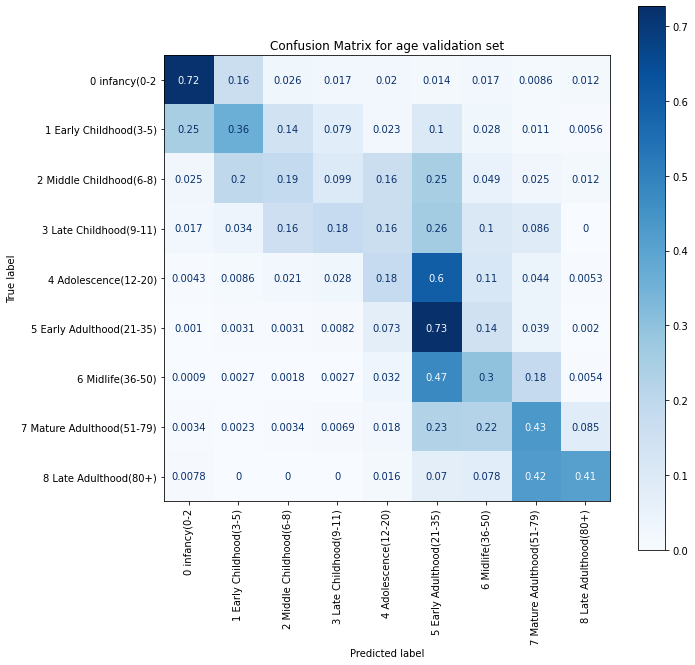

In [72]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

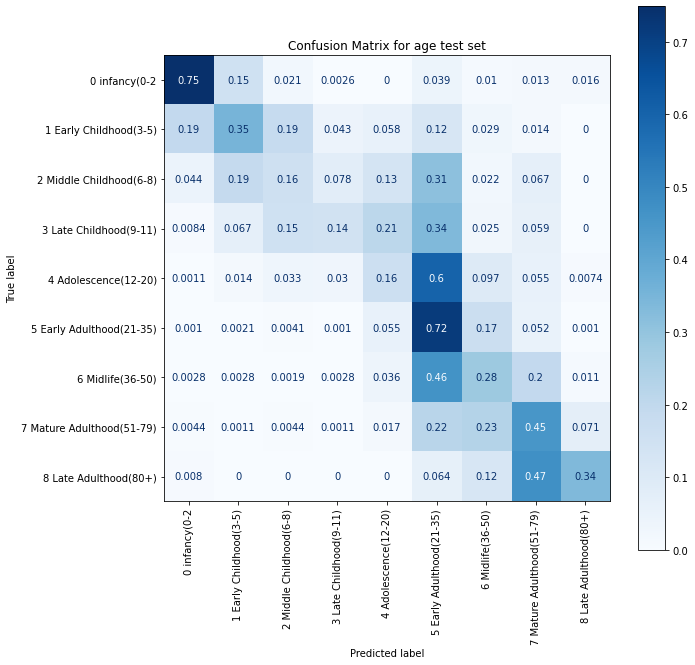

In [73]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

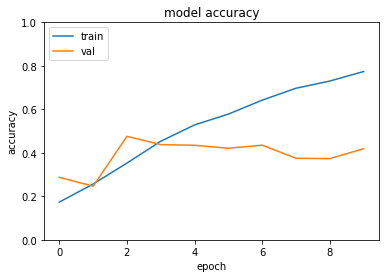

In [74]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

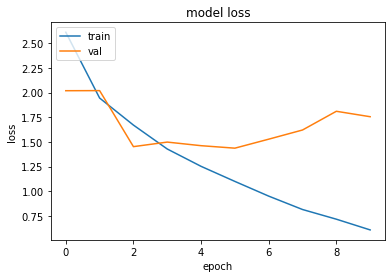

In [75]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prepare SIFT dataset

In [13]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True).astype(np.uint8)

In [14]:
descriptors = get_descriptors(train_img_container,100)

In [22]:
vocab = get_vocab(descriptors[:500],200)

In [23]:
histarraytrain = descriptor_to_vocab(train_img_container,vocab)

In [25]:
histarrayval = descriptor_to_vocab(get_images(X_val,rgb = True).astype(np.uint8),vocab)

In [26]:
histarraytest = descriptor_to_vocab(get_images(X_test,rgb = True).astype(np.uint8),vocab)

In [27]:
histarraytrain = normalize_histograms(histarraytrain)

C:\Users\thanh\Documents\GitHub\Facial-Attribute-Classification-by-ML\Notebooks\SIFT_to_Features.ipynb:71: RuntimeWarning: invalid value encountered in true_divide
  "        for j in bin_assignment:\n",


In [31]:
histarrayval = normalize_histograms(histarrayval)

In [32]:
histarraytest = normalize_histograms(histarraytest)

In [33]:
histarraytrain = np.nan_to_num(histarraytrain)
histarrayval = np.nan_to_num(histarrayval)
histarraytest = np.nan_to_num(histarraytest)

In [55]:
histarraytrain = np.expand_dims(histarraytrain, axis=2)
histarrayval = np.expand_dims(histarrayval, axis=2)
histarrayest = np.expand_dims(histarraytest, axis=2)

### Train 1D SIFT model

In [53]:
Modelsimple=Simplemodel1D(np.expand_dims(histarraytrain, axis=2)[0].shape,'age')

In [54]:
History = Modelsimple.fit(np.expand_dims(histarraytrain, axis=2)
                          ,y_train_label
                          ,validation_data=(np.expand_dims(histarrayval, axis=2),y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 3s 13ms/step - loss: 2.1781 - accuracy: 0.1377 - val_loss: 2.2484 - val_accuracy: 0.1196
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 2.0614 - accuracy: 0.2162 - val_loss: 2.2235 - val_accuracy: 0.1363
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 1.9779 - accuracy: 0.2573 - val_loss: 2.0044 - val_accuracy: 0.2421
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 1.9061 - accuracy: 0.2909 - val_loss: 2.1031 - val_accuracy: 0.1495
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 1.8005 - accuracy: 0.3351 - val_loss: 2.0784 - val_accuracy: 0.2168
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 1.6660 - accuracy: 0.4024 - val_loss: 1.8623 - val_accuracy: 0.3164
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 1.4863 - accuracy: 0.4667 - val_loss: 2.1951 - val_accuracy: 0.2118

### Get predictions

In [57]:
histarraytest.shape

(4741, 200)

In [58]:
ypredtrain = Modelsimple.predict(histarraytrain)
ypredtest = Modelsimple.predict(histarrayest)
ypredval = Modelsimple.predict(histarrayval)

149/149 [==============================] - 0s 3ms/step


### Train classification report

In [59]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       585
           1       0.79      0.86      0.82       510
           2       0.83      0.83      0.83       559
           3       0.87      0.92      0.90       525
           4       0.61      0.80      0.69       426
           5       0.84      0.53      0.65       885
           6       0.59      0.72      0.65       457
           7       0.61      0.71      0.65       471
           8       0.87      0.84      0.85       577

    accuracy                           0.77      4995
   macro avg       0.77      0.78      0.77      4995
weighted avg       0.78      0.77      0.77      4995



### Validation classification report

In [60]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.35      0.50      0.41       308
           1       0.07      0.14      0.09       157
           2       0.05      0.16      0.07        95
           3       0.07      0.12      0.09        92
           4       0.10      0.11      0.10       336
           5       0.53      0.40      0.45      2073
           6       0.18      0.14      0.16       806
           7       0.25      0.20      0.22       729
           8       0.12      0.30      0.17       145

    accuracy                           0.29      4741
   macro avg       0.19      0.23      0.20      4741
weighted avg       0.34      0.29      0.30      4741



### Test classification report

In [61]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.35      0.43      0.39       328
           1       0.04      0.07      0.05       150
           2       0.03      0.10      0.05       107
           3       0.06      0.16      0.08        64
           4       0.11      0.14      0.12       304
           5       0.52      0.41      0.46      2064
           6       0.18      0.14      0.16       793
           7       0.23      0.16      0.18       799
           8       0.12      0.31      0.17       132

    accuracy                           0.28      4741
   macro avg       0.18      0.21      0.19      4741
weighted avg       0.33      0.28      0.30      4741



### Set labels and title based on label type

In [62]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

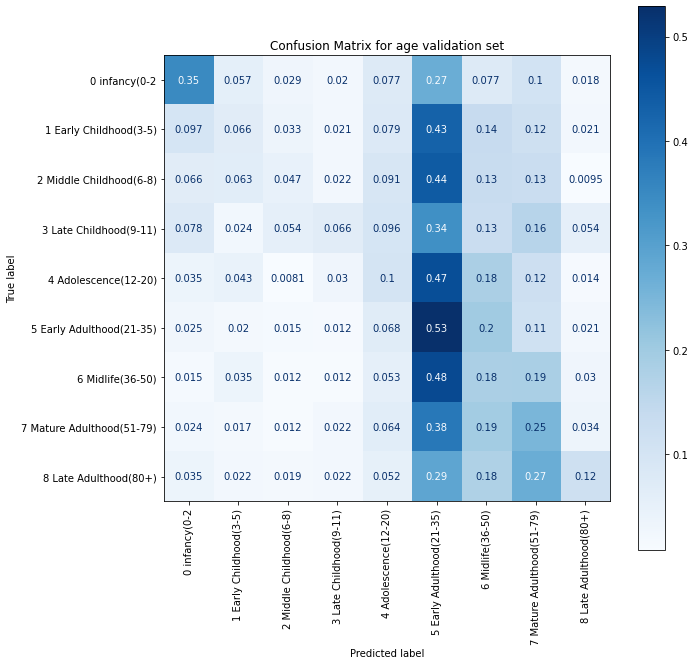

In [63]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

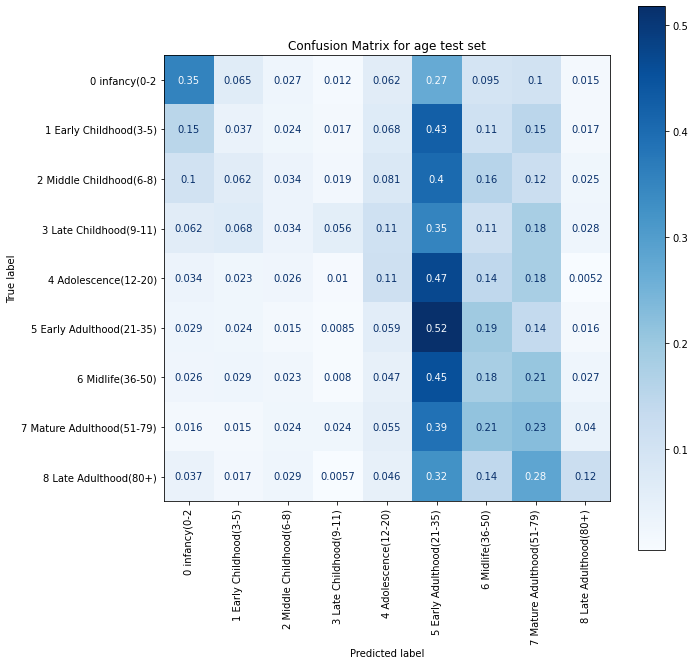

In [64]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

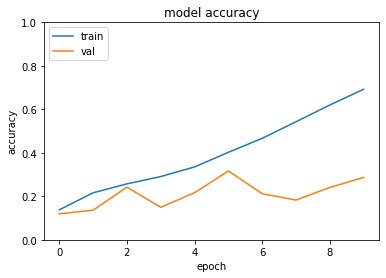

In [65]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

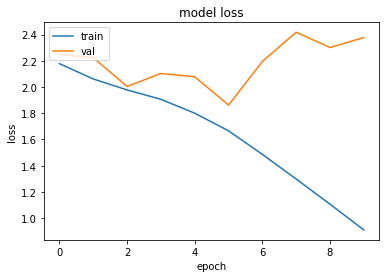

In [66]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prepare PCA dataset

In [67]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

In [68]:
train_img_container = train_img_container.reshape(len(train_img_container),200*200*3)
validation_img_container = validation_img_container.reshape(len(validation_img_container),200*200*3)
test_img_container = test_img_container.reshape(len(test_img_container),200*200*3)

In [70]:
pcax = PCA(n_components = 200)
pcax.fit(train_img_container)
train_img_container = pcax.transform(train_img_container)
validation_img_container = pcax.transform(validation_img_container)
test_img_container = pcax.transform(test_img_container)

In [73]:
train_img_container = np.expand_dims(train_img_container, axis=2)
validation_img_container = np.expand_dims(validation_img_container, axis=2)
test_img_container = np.expand_dims(test_img_container, axis=2)

### Develop PCA model

In [79]:
Modelsimple=Simplemodel1D(train_img_container[0].shape,'age')

In [80]:
Modelsimple.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 200, 32)           128       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 50, 64)            1235

In [81]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(np.expand_dims(validation_img_container, axis=2),y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 3s 15ms/step - loss: 9.0172 - accuracy: 0.1179 - val_loss: 2.1945 - val_accuracy: 0.0300
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 2.1888 - accuracy: 0.1135 - val_loss: 2.1944 - val_accuracy: 0.1563
Epoch 3/10
157/157 [==============================] - 2s 13ms/step - loss: 2.1718 - accuracy: 0.1415 - val_loss: 2.2187 - val_accuracy: 0.1673
Epoch 4/10
157/157 [==============================] - 2s 13ms/step - loss: 2.1426 - accuracy: 0.1516 - val_loss: 2.2024 - val_accuracy: 0.1725
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 2.1189 - accuracy: 0.1656 - val_loss: 2.1954 - val_accuracy: 0.4058
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 2.1068 - accuracy: 0.1718 - val_loss: 2.1534 - val_accuracy: 0.1704
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 2.0847 - accuracy: 0.1816 - val_loss: 2.1541 - val_accuracy: 0.1787

### Get predictions

In [82]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 1s 4ms/step


### Train classification report

In [83]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       550
           1       0.15      0.18      0.17       464
           2       0.05      0.18      0.08       166
           3       0.03      0.69      0.06        26
           4       0.03      0.16      0.04        85
           5       0.24      0.22      0.23       615
           6       0.12      0.41      0.18       158
           7       0.69      0.13      0.22      2915
           8       0.01      0.44      0.02        16

    accuracy                           0.20      4995
   macro avg       0.20      0.33      0.17      4995
weighted avg       0.51      0.20      0.24      4995



### Validation classification report

In [84]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.55      0.38      0.45       308
           1       0.10      0.20      0.14       157
           2       0.03      0.04      0.04        95
           3       0.00      0.00      0.00        92
           4       0.13      0.03      0.05       336
           5       0.48      0.20      0.28      2073
           6       0.21      0.05      0.08       806
           7       0.15      0.60      0.24       729
           8       0.08      0.01      0.01       145

    accuracy                           0.22      4741
   macro avg       0.19      0.17      0.14      4741
weighted avg       0.32      0.22      0.21      4741



### Test classification report

In [85]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.34      0.39       328
           1       0.07      0.14      0.10       150
           2       0.06      0.07      0.07       107
           3       0.00      0.00      0.00        64
           4       0.07      0.02      0.03       304
           5       0.49      0.20      0.29      2064
           6       0.24      0.05      0.08       793
           7       0.17      0.64      0.27       799
           8       0.00      0.00      0.00       132

    accuracy                           0.24      4741
   macro avg       0.18      0.16      0.14      4741
weighted avg       0.32      0.24      0.22      4741



### Set labels and title based on label type

In [86]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

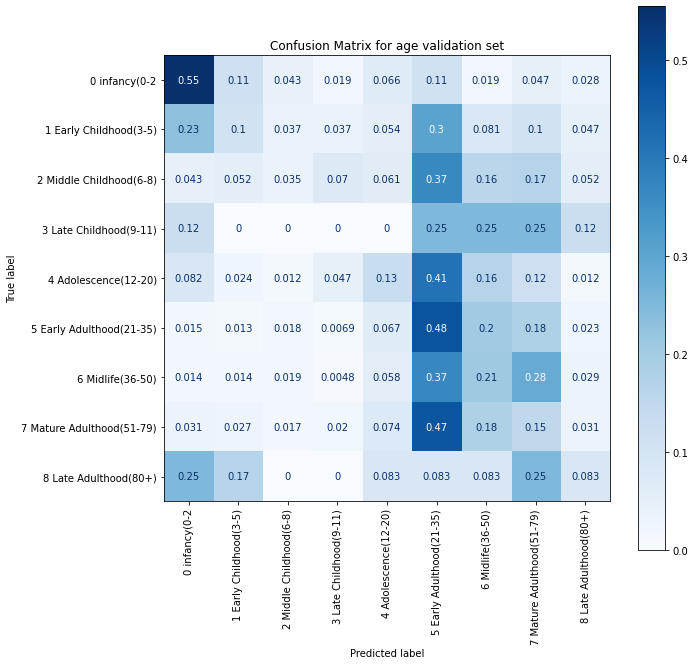

In [87]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

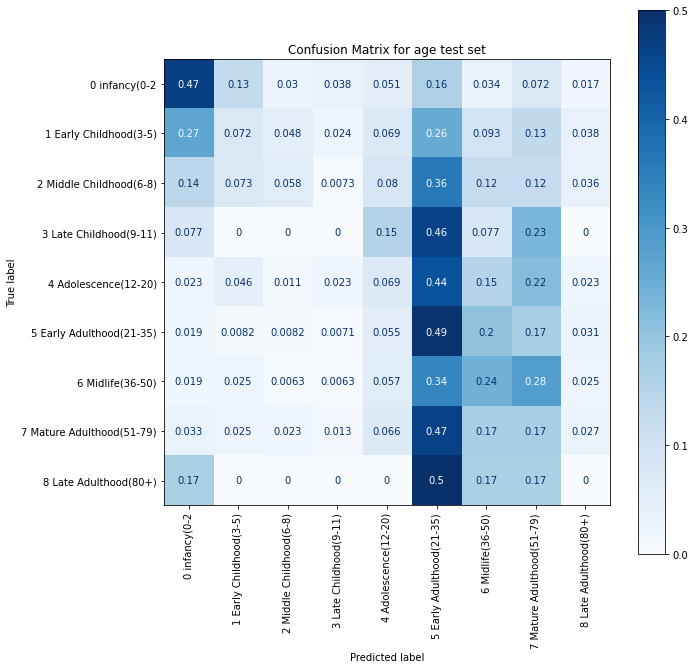

In [88]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

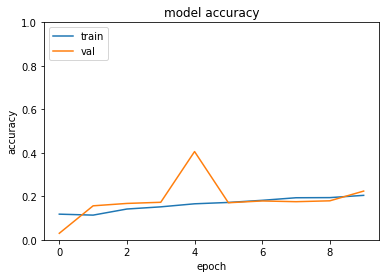

In [89]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

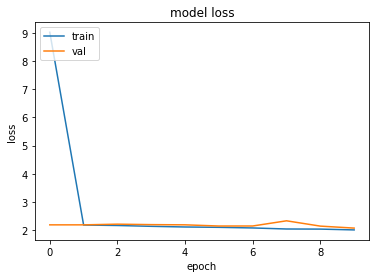

In [90]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prepare RFS dataset

In [108]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

In [109]:
train_img_container = train_img_container.reshape(len(train_img_container),200*200*3)
validation_img_container = validation_img_container.reshape(len(validation_img_container),200*200*3)
test_img_container = test_img_container.reshape(len(test_img_container),200*200*3)

In [110]:
selector = SelectFromModel(RandomForestClassifier())
selector.fit(train_img_container, y_train_label)

SelectFromModel(estimator=RandomForestClassifier())

In [111]:
train_img_container = train_img_container[:,selector.get_support()]
validation_img_container = validation_img_container[:,selector.get_support()]
test_img_container = test_img_container[:,selector.get_support()]

In [112]:
train_img_container = np.expand_dims(train_img_container, axis=2)
validation_img_container = np.expand_dims(validation_img_container, axis=2)
test_img_container = np.expand_dims(test_img_container, axis=2)

### Develop RFS model

In [113]:
Modelsimple=Simplemodel1D(train_img_container[0].shape,'age')

In [114]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 257s 2s/step - loss: 13.8846 - accuracy: 0.2801 - val_loss: 2.0288 - val_accuracy: 0.2080
Epoch 2/10
157/157 [==============================] - 246s 2s/step - loss: 1.2403 - accuracy: 0.5499 - val_loss: 1.6474 - val_accuracy: 0.3550
Epoch 3/10
157/157 [==============================] - 247s 2s/step - loss: 0.8212 - accuracy: 0.7133 - val_loss: 1.7004 - val_accuracy: 0.4200
Epoch 4/10
157/157 [==============================] - 248s 2s/step - loss: 0.5130 - accuracy: 0.8196 - val_loss: 2.1764 - val_accuracy: 0.3641
Epoch 5/10
157/157 [==============================] - 248s 2s/step - loss: 0.3366 - accuracy: 0.8861 - val_loss: 2.6388 - val_accuracy: 0.3883
Epoch 6/10
157/157 [==============================] - 246s 2s/step - loss: 0.2251 - accuracy: 0.9299 - val_loss: 2.6520 - val_accuracy: 0.4128
Epoch 7/10
157/157 [==============================] - 247s 2s/step - loss: 0.1330 - accuracy: 0.9604 - val_loss: 2.7087 - val_accuracy: 0.373

### Get predictions

In [115]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 44s 296ms/step


### Train classification report

In [116]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       571
           1       0.94      0.98      0.95       532
           2       0.99      0.92      0.95       595
           3       0.93      0.98      0.95       526
           4       0.95      0.94      0.94       563
           5       0.92      0.93      0.92       550
           6       0.91      0.98      0.94       515
           7       0.99      0.81      0.89       680
           8       0.82      0.99      0.90       463

    accuracy                           0.94      4995
   macro avg       0.94      0.94      0.94      4995
weighted avg       0.94      0.94      0.94      4995



### Validation classification report

In [117]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       308
           1       0.26      0.22      0.24       157
           2       0.12      0.43      0.19        95
           3       0.16      0.21      0.18        92
           4       0.14      0.25      0.18       336
           5       0.69      0.37      0.49      2073
           6       0.29      0.30      0.30       806
           7       0.36      0.55      0.43       729
           8       0.22      0.34      0.27       145

    accuracy                           0.39      4741
   macro avg       0.34      0.38      0.34      4741
weighted avg       0.49      0.39      0.41      4741



### Test classification report

In [118]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       328
           1       0.27      0.26      0.27       150
           2       0.15      0.44      0.23       107
           3       0.13      0.23      0.17        64
           4       0.16      0.30      0.21       304
           5       0.70      0.37      0.48      2064
           6       0.31      0.31      0.31       793
           7       0.42      0.59      0.49       799
           8       0.17      0.32      0.22       132

    accuracy                           0.41      4741
   macro avg       0.34      0.40      0.35      4741
weighted avg       0.51      0.41      0.43      4741



### Set labels and title based on label type

In [119]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

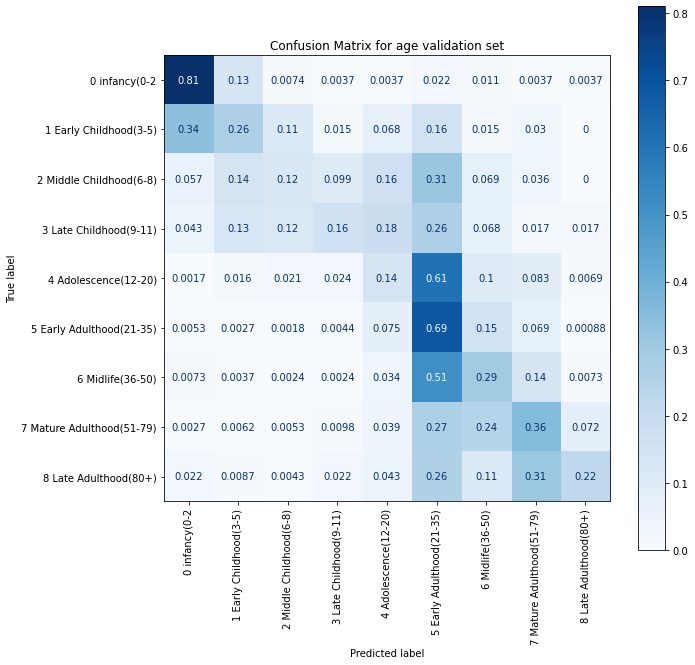

In [120]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

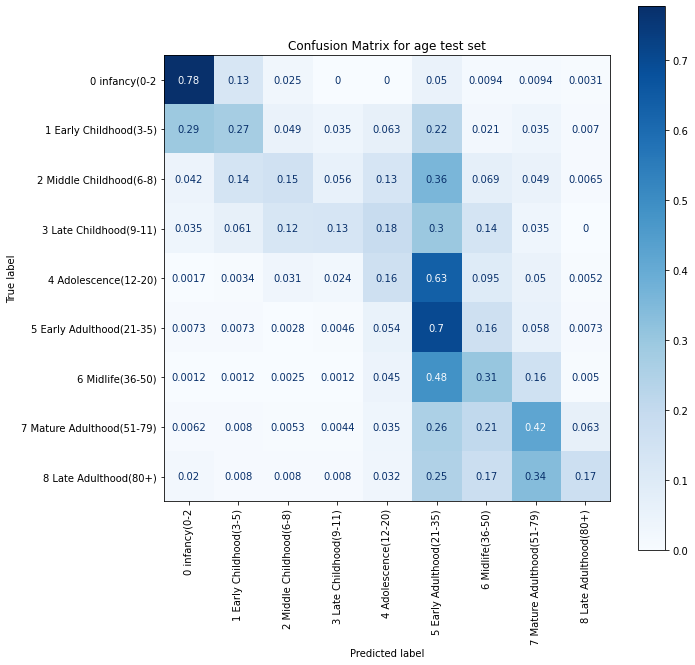

In [121]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

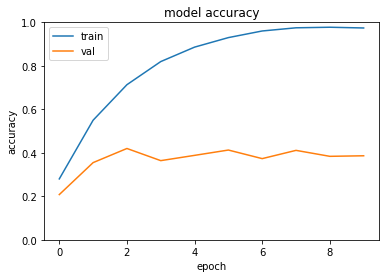

In [122]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

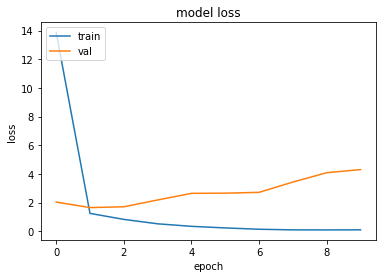

In [123]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()